In [2]:
import sys
import pdb
import copy
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 13,   # Axis labels
    'xtick.labelsize' : 11,   # X-axis tick labels
    'ytick.labelsize' : 11,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance
cmn         = putil.get_cmap_norm

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/wavePaperFigs/util')
import nclcmaps as ncm

This notebook generates figures of U impact, and U forcing by EP flux divergence, the residual circulation, and parameterized sources, for a given slice of time, latitude, and pressure. The data is averaged over the time limits, and displayed over the latitude and pressure limits. If the time limits align with the first of the month on each end, monthly mean data will be used, in which case the gravity wave contribution to the parameterized forcing will be separated.

In [3]:
importlib.reload(putil)
importlib.reload(ces)

def make_plot(latlim, plim, tlim, ulev, ilev, tendlev, 
              inorm='twoslope', tendnorm='uneven', sigvar='pvalue', 
              epvscale=1e13, epdslat=4, epdsp=2, filter_uimpact_contours=True, 
              rvvscale=None, rvdslat=4, rvdsp=2, log_resvel_vectors=False, 
              lat_ticks=None, interp_vectors=False):
    
    # if the specified time limits start and end on the first of a month, 
    # the use the monthly-mean data for the plots.
    # In this case, the gravity wave forcing will be separated out
    # from the total parameterized tendency (3 forcing components are shown)
    # Otherwise, use the 10-daily data.
    # In that case, the gravity waves are not separated (4 components are shown)
    tmin, tmax = tlim[0], tlim[1]
    if tmin.day==1 and tmax.day==1: data_freq='monthly'
    else:                           data_freq='10daily'
    monthly = data_freq == 'monthly'
    
    pcrit = 0.05         # threshold in p-value to determine significance
    
    # ----- read data
    rargs = {'tmin':tmin, 'tmax':tmax, 'freq':data_freq}
    u            = putil.get_variable('U', **rargs)
    trop         = putil.get_variable('TROP_P', **rargs)
    epdiv        = putil.get_variable('epdiv', **rargs)
    epfy         = putil.get_variable('epfy', **rargs)
    epfz         = putil.get_variable('epfz', **rargs)
    vtem         = putil.get_variable('vtem', **rargs)
    wtem         = putil.get_variable('wtem', **rargs)
    omtem        = putil.get_variable('omegatem', **rargs)
    psitem       = putil.get_variable('psitem', **rargs)
    psitem_glat  = putil.get_variable('psitem_gradlat', **rargs)
    psitem_gp    = putil.get_variable('psitem_gradp', **rargs)
    utendepfd    = putil.get_variable('utendepfd', **rargs)
    utendvtem    = putil.get_variable('utendvtem', **rargs)
    utendwtem    = putil.get_variable('utendwtem', **rargs)
    utendresvel  = putil.get_variable('utendresvel', **rargs)
    utenddiff    = putil.get_variable('utenddiff', **rargs)
    if(monthly):
        utendgw = putil.get_variable('utendgw', **rargs)
    dkeys = u.keys()
        
    # ----- slice data
    pmin, pmax     = plim[0], plim[1]
    latmin, latmax = latlim[0], latlim[1]
    sargs = {'pmin':pmin, 'pmax':pmax, 'latmin':latmin, 'latmax':latmax}
    u            = putil.do_slicing(u, **sargs)
    trop         = putil.do_slicing(trop, latmin=latmin, latmax=latmax)
    epdiv        = putil.do_slicing(epdiv, **sargs)
    epfy         = putil.do_slicing(epfy, **sargs)
    epfz         = putil.do_slicing(epfz, **sargs)
    vtem         = putil.do_slicing(vtem, **sargs)
    wtem         = putil.do_slicing(wtem, **sargs)
    omtem        = putil.do_slicing(omtem, **sargs)
    psitem       = putil.do_slicing(psitem, **sargs)
    psitem_glat  = putil.do_slicing(psitem_glat, **sargs)
    psitem_gp    = putil.do_slicing(psitem_gp, **sargs)
    utendepfd    = putil.do_slicing(utendepfd, **sargs)
    utendvtem    = putil.do_slicing(utendvtem, **sargs)
    utendwtem    = putil.do_slicing(utendwtem, **sargs)
    utendresvel  = putil.do_slicing(utendresvel, **sargs)
    utenddiff    = putil.do_slicing(utenddiff, **sargs)
    if(monthly):
        utendgw = putil.do_slicing(utendgw, **sargs)
        
    # ----- get filtered uimpact significance
    u_impact_sig = putil.filter_significance(u['impact'], u['pval'], thresh=pcrit, fill=0)
    
    # ----- get coords
    lat, plev = u['cfmean'].lat, u['cfmean'].plev
    
    # ----- scale tendencies to m/s/month
    spm = 30*24*60*60
    for k in ['cfmean', 'ensmean', 'impact']:
        for tend in [utendepfd, utendresvel, utenddiff]:
            tend[k] = tend[k] * spm
        if(monthly):
            utendgw[k] = utendgw[k] * spm
    
    # ==================== PLOT ====================
    
    # get aspect ratio of each axes, defined to be square for one hemisphere
    #aspect = (latmax-latmin) / 90
    aspect = 70/90
    numax  = [4, 5][monthly]
    
    # create figure, axes
    fig_width  = 12
    fig_height = fig_width/numax/aspect
    fig, ax = plt.subplots(1, numax, figsize=(fig_width, fig_height))
    ax1, ax2, ax3, ax4 = ax[0], ax[1], ax[2], ax[3]
    if(monthly):
        ax4 = ax[4]
        ax5 = ax[3]
    
    # ----- plotting settings
    tlw, tls, tcolor      = 3,'-','grey' # line width, style, and color for tropopause     
    ulw, ucolor           = 0.8, 'k'     # linewidths and color for U contours
    ulwz                  = ulw*1.7      # line width for U zero-line contour
    uilw, uicolor           = 1.5, 'darkorchid'      # linewidths and color for U impact contours
    uilwz                  = uilw*1.7      # line width for U impact zero-line contour
    uicmap                = 'RdBu_r'     # colormap for U impact
    isiglw, isigcolor     = 2.5, 'w'     # linwdith and color for significance contours
    ihatch                = '/////'      # insignificance hatching type
    ihatchtend            = '//////'    # insignificance hatching type for tendencies
    ihatchlw, ihatchcolor = 1, 'w'       # linewidth and color for insignificance hatching
    #tendcmap              = 'RdYlBu_r' # colormap for tendency component impacts
    tendcmap              = 'BrBG_r' # colormap for tendency component impacts
    dslat                 = 4            # latitude downsampling factor for EP flux vectors
    dsp                   = 1.5          # pressure downsampling factor for EP flux vectors
    vw, vhw, vhl          = 0.02,2.7,4   # vector arrow width, head width, and head length to quiver()
    vcolor                = 'k'         # vector arrow color
    vecolor               = 'w'         # vector outline color
    vlw                   = 0.7        # vector outline linewidth
    dslat                 = epdslat        # latitudinal coarsening factor for EP vectors
    dsp                   = epdsp        # latitudinal coarsening factor for EP vectors
    mpl.rcParams['hatch.linewidth'] = ihatchlw
    mpl.rcParams['hatch.color']     = ihatchcolor
    
    # ----- plot U impact over U
    # U
    ax1.contour(lat, plev, u['cfmean'].T, levels=ulev, linewidths=ulw, colors=ucolor, zorder=10)
    ax1.contour(lat, plev, u['cfmean'].T, levels=[0], linewidths=ulwz, colors=ucolor, zorder=10)
    # U impact
    uicontour = ax1.contourf(lat, plev, u['impact'].T, levels=ilev, cmap=uicmap, norm=cmn(ilev,inorm), extend='both')
    # significance
    uisigcontour = ax1.contour(lat, plev, u['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    ax1.contourf(lat, plev, u['pval'].T, levels=[pcrit, u['pval'].max()], hatches=[ihatch], alpha=0)
    # title
    ax1.set_title('$\\overline{{u}}$ impact', fontsize=13)
    
    # ----- plot U impact over EP flux divergence forcing
    # U impact
    if(filter_uimpact_contours):
        putil.plot_significance_filtered_contours(ax2, lat, plev, u['impact'].T, ilev, u['pval'].T, lw=uilw, color=uicolor, zorder=10)
        putil.plot_significance_filtered_contours(ax2, lat, plev, u['impact'].T, [0], u['pval'].T, lw=uilwz, color=uicolor, zorder=10)
    else:
        ax2.contour(lat, plev, u['impact'].T, levels=ilev, linewidths=uilw, colors=ucolor, zorder=10)
        ax2.contour(lat, plev, u['impact'].T, levels=[0], linewidths=uilwz, colors=ucolor, zorder=10)
    # utendepfd
    utcontour = ax2.contourf(lat, plev, utendepfd['impact'].T, levels=tendlev, cmap=tendcmap, norm=cmn(tendlev,tendnorm), extend='both')
    # significance
    ax2.contourf(lat, plev, utendepfd['pval'].T, levels=[pcrit, utendepfd['pval'].max()], hatches=[ihatchtend], alpha=0)
    ax2.contour(lat, plev, utendepfd['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    # title
    ax2.set_title('$\\partial\\overline{u}/\\partial t$ by $\\nabla\\cdot$F', fontsize=13)
    
    # ----- plot U impact over residual velocity forcing
    if(filter_uimpact_contours):
        putil.plot_significance_filtered_contours(ax3, lat, plev, u['impact'].T, ilev, u['pval'].T, lw=uilw, color=uicolor, zorder=10)
        putil.plot_significance_filtered_contours(ax3, lat, plev, u['impact'].T, [0], u['pval'].T, lw=uilwz, color=uicolor, zorder=10)
    else:
        ax3.contour(lat, plev, u['impact'].T, levels=ilev, linewidths=uilw, colors=ucolor, zorder=10)
        ax3.contour(lat, plev, u['impact'].T, levels=[0], linewidths=uilwz, colors=ucolor, zorder=10)
    # utendresvel
    ax3.contourf(lat, plev, utendresvel['impact'].T, levels=tendlev, cmap=tendcmap, norm=cmn(tendlev,tendnorm), extend='both')
    # significance
    ax3.contourf(lat, plev, utendresvel['pval'].T, levels=[pcrit, utendresvel['pval'].max()], hatches=[ihatchtend], alpha=0)
    ax3.contour(lat, plev, utendresvel['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    # title
    ax3.set_title('$\\partial\\overline{u}/\\partial t$ by $(v^*, w^*)$', fontsize=13)
    
    # ----- plot U impact over parameterized forcing
    if(filter_uimpact_contours):
        putil.plot_significance_filtered_contours(ax4, lat, plev, u['impact'].T, ilev, u['pval'].T, lw=uilw, color=uicolor, zorder=10)
        putil.plot_significance_filtered_contours(ax4, lat, plev, u['impact'].T, [0], u['pval'].T, lw=uilwz, color=uicolor, zorder=10)
    else:
        ax4.contour(lat, plev, u['impact'].T, levels=ilev, linewidths=uilw, colors=ucolor, zorder=10)
        ax4.contour(lat, plev, u['impact'].T, levels=[0], linewidths=uilwz, colors=ucolor, zorder=10)
    # utenddiff
    ax4.contourf(lat, plev, utenddiff['impact'].T, levels=tendlev, cmap=tendcmap, norm=cmn(tendlev,tendnorm), extend='both')
    # significance
    ax4.contourf(lat, plev, utenddiff['pval'].T, levels=[pcrit, utenddiff['pval'].max()], hatches=[ihatchtend], alpha=0)
    ax4.contour(lat, plev, utenddiff['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    # title
    ax4.set_title('$\\partial\\overline{u}/\\partial t$ residual', fontsize=13)
    
    # ----- plot U impact over gravity wave forcing
    if(monthly):
        if(filter_uimpact_contours):
            putil.plot_significance_filtered_contours(ax5, lat, plev, u['impact'].T, ilev, u['pval'].T, lw=uilw, color=uicolor, zorder=10)
            putil.plot_significance_filtered_contours(ax5, lat, plev, u['impact'].T, [0], u['pval'].T, lw=uilwz, color=uicolor, zorder=10)
        else:
            ax5.contour(lat, plev, u['impact'].T, levels=ilev, linewidths=uilw, colors=ucolor, zorder=10)
            ax5.contour(lat, plev, u['impact'].T, levels=[0], linewidths=uilwz, colors=ucolor, zorder=10)
        # utendgw
        ax5.contourf(lat, plev, utendgw['impact'].T, levels=tendlev, cmap=tendcmap, norm=cmn(tendlev,tendnorm), extend='both')
        # significance
        ax5.contourf(lat, plev, utendgw['pval'].T, levels=[pcrit, utendgw['pval'].max()], hatches=[ihatchtend], alpha=0)
        ax5.contour(lat, plev, utendgw['pval'].T, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
        # title
        ax5.set_title('$\\partial\\overline{u}/\\partial t$ by GW', fontsize=13)
        
    # ---- plot tropopause for all axes
    for axi in ax:
        #continue
        axi.plot(lat, trop['cfmean']/100, lw=tlw, ls=tls, color=tcolor)
        
    # ----- format
    for i in range(numax):
        putil.format_paxis(ax[i])
        putil.format_lat_ticks(ax[i], ticks=lat_ticks)
        ax[i].set_ylim([plev.max(), plev.min()])
        ax[i].set_xlim([lat.min(), lat.max()])
        labelleft = [False, True][i == 0]
        labelright = [False, True][i == numax-1]
        ax[i].tick_params(left=True, right=True, top=True, bottom=True, 
                          labelleft=labelleft, labelright=labelright, 
                          labeltop=False, labelbottom=True, which='both')
    ax[0].set_ylabel('pressure [hPa]')
    ax[-1].set_ylabel('pressure [hPa]')
    ax[-1].yaxis.set_label_position('right')
    fig.subplots_adjust(wspace=0.07)

    # ----- scale EP flux vectors, and delete insignificant, and plot
    # first interpolate the vector field to a uniform grid in lat-log(p)
    if(interp_vectors):
        epfyi, epfzi, epfyis, epfzis = putil.regrid_vectors_latp(epfy['impact'], epfz['impact'], 
                                                                                epfy['pval'], epfz['pval'])
    else:
        epfyi, epfzi, epfyis, epfzis = epfy['impact'], epfz['impact'], epfy['pval'], epfz['pval']
    # next filter out insignificant vectors
    epfyi, epfzi = putil.filter_vector_significance(epfyi, epfzi, epfyis, epfzis)
    # next remove vectors in the troposphere so that they don't influence the length scaling
    pbuff = 20
    epfyi = putil.remove_troposphere(epfyi, trop['cfmean'], buffer=pbuff)
    epfzi = putil.remove_troposphere(epfzi, trop['cfmean'], buffer=pbuff)
    # finally do EP flux vector scaling
    # This MUST be done last so that the vector scaling is not corrupted by later 
    # modifications to the figure or axes size or data limits
    Fx, Fy = putil.scale_EP_flux_vectors(fig, ax2, epfyi, epfzi, dslat=dslat, dsp=dsp, 
                                         dsplog=False, interp_lat=False, interp_plev=False)
    # plot filtered, scaled vector field
    LAT, PLEV = np.meshgrid(Fx.lat, Fx.plev)
    qvep = ax2.quiver(LAT, PLEV, Fx.T, Fy.T, width=vw, headwidth=vhw, headlength=vhl, headaxislength=vhl*0.9, 
               scale=epvscale, scale_units='inches', color=vcolor, zorder=20, edgecolor=vecolor, linewidth=vlw)
    
    # ----- plot residual velocity vectors
    # first interpolate the vector field to a uniform grid in lat-log(p)
    if(interp_vectors):
        glati, gpi, glatis, gpis = putil.regrid_vectors_latp(psitem_glat['impact'], psitem_gp['impact'], 
                                                                            psitem_glat['pval'], psitem_gp['pval'])
    else:
        glati, gpi, glatis, gpis = psitem_glat['impact'], psitem_gp['impact'], psitem_glat['pval'], psitem_gp['pval']
    # next filter out insignificant vectors
    glati, gpi = putil.filter_vector_significance(glati, gpi, glatis, gpis)
    # next remove vectors in the troposphere so that they don't influence the length scaling
    pbuff = 20
    glati = putil.remove_troposphere(glati, trop['cfmean'], buffer=pbuff)
    gpi   = putil.remove_troposphere(gpi, trop['cfmean'], buffer=pbuff)
    # finally get gradient-normal field from streamfunction
    gnx, gny = putil.streamfunction_gradient_normal(fig, ax3, dfdlat=glati, dfdp=gpi, dslat=rvdslat, dsp=rvdsp, 
                                                    dsplog=False, interp_lat=False, interp_plev=False, 
                                                    log_vectors=log_resvel_vectors)
    # plot filtered, scaled vector field
    LAT, PLEV = np.meshgrid(gnx.lat, gnx.plev)
    qvrv = ax3.quiver(LAT, PLEV, gnx.T, gny.T, scale=rvvscale, width=vw, headwidth=vhw, headlength=vhl, headaxislength=vhl*0.9, 
                      color=vcolor, zorder=20, edgecolor=vecolor, linewidth=vlw)
    
    # ----- colorbars
    # -- for U impact
    cbpos = [0.125, 0.98, 0.146, 0.06] # colorbar position
    cb = fig.colorbar(uicontour, cax=fig.add_axes(cbpos), orientation='horizontal', location='top', format='%d', extendrect=True)
    cb.set_label('')
    cb.set_ticks(ilev)
    cb.ax.xaxis.set_label_position('bottom')
    cb.ax.set_ylabel('[m/s]\n')
    # -- for tendencies
    cbpos = [0.282, 0.98, 0.618, 0.06] # colorbar position
    cb = fig.colorbar(utcontour, cax=fig.add_axes(cbpos), orientation='horizontal', location='top', format=putil.pretty_format_colorbar(), extendrect=True)
    #cb.set_label('$\\overline{{u}}$ tendency impact [m/s/month]')
    cb.set_label('')
    cb.set_ticks(tendlev)
    cb.ax.xaxis.set_label_position('bottom')
    cb.ax.set_ylabel('\n\n[m/s/\nmonth]')
    cb.ax.yaxis.set_label_position('right')
    
    # ---- legends
    ax1.plot([0,0],[0,0], color=ucolor, lw=ulw,label='counterfactual $\\overline{{u}}$ every {} m/s'.format(np.diff(ulev)[0]))
    ax1.plot([0,0],[0,0], color=uicolor, lw=uilw,label='significant $\\overline{{u}}$ impact every {} m/s'.format(np.diff(ilev)[0]))
    ax1.quiverkey(qvep, X=2.15, Y=-0.19, U=epvscale/2, label='significant E-P flux impact vectors', labelpos='E', fontproperties={'size':11})
    ax1.quiverkey(qvrv, X=1.08, Y=-0.29, U=rvvscale/3.5, label='significant $\\Psi^*$ impact vectors', labelpos='E', fontproperties={'size':11})
    
    leg = ax1.legend(bbox_to_anchor=(2.9, -0.08), frameon=False, fancybox=False, edgecolor='k', handlelength=1.5, fontsize=11)
    leg.get_frame().set_linewidth(0.66)
    
    ax1.set_xlabel('\n{}-{}'.format(putil.to_datetime(tlim[0]).strftime('%b %Y'), putil.to_datetime(tlim[1]).strftime('%b %Y')))


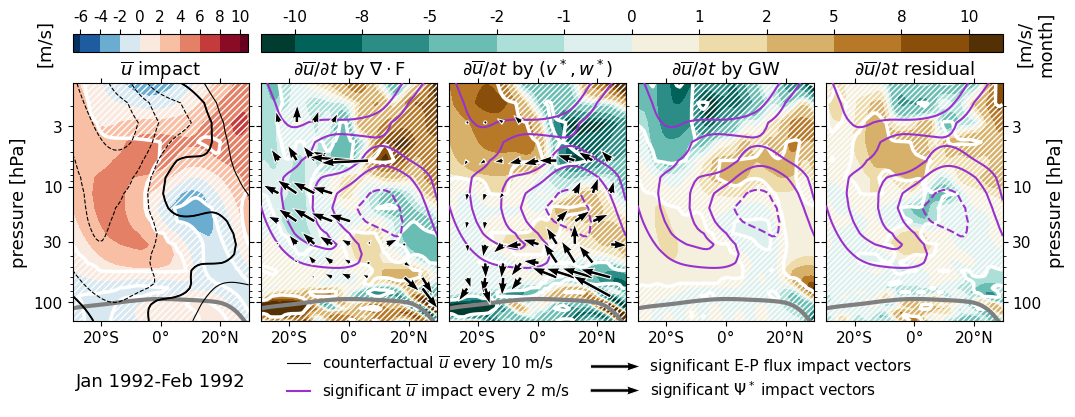

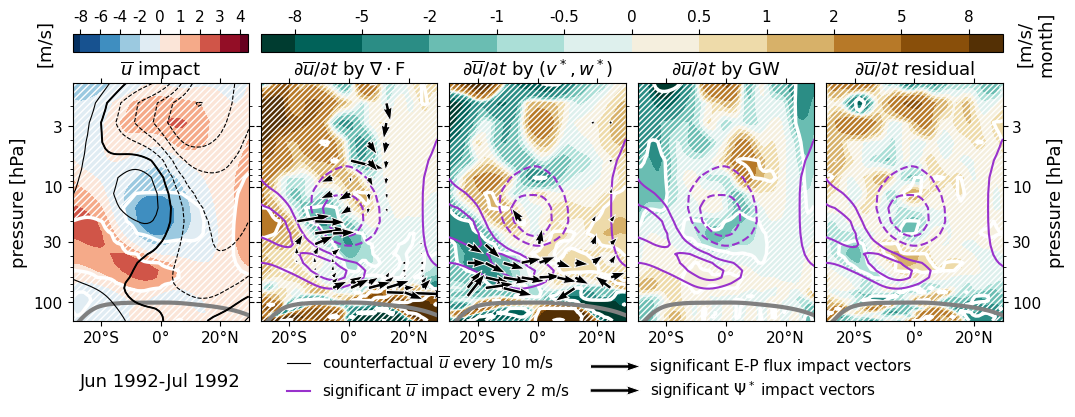

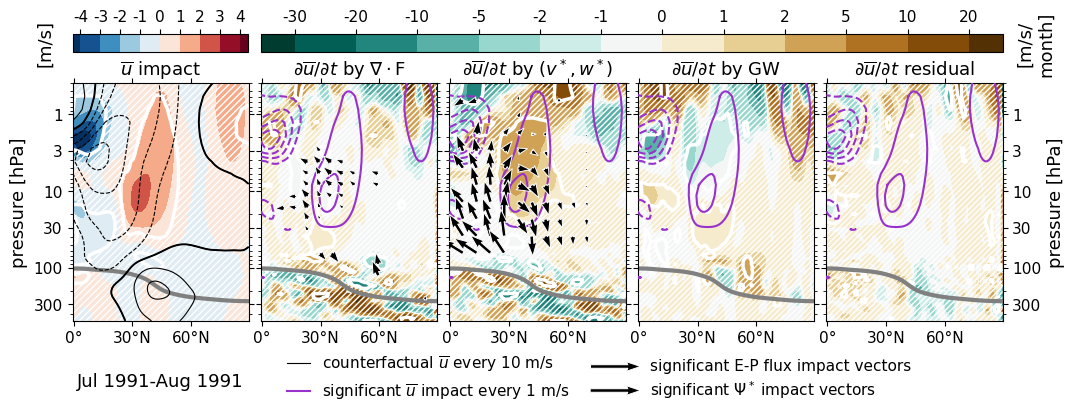

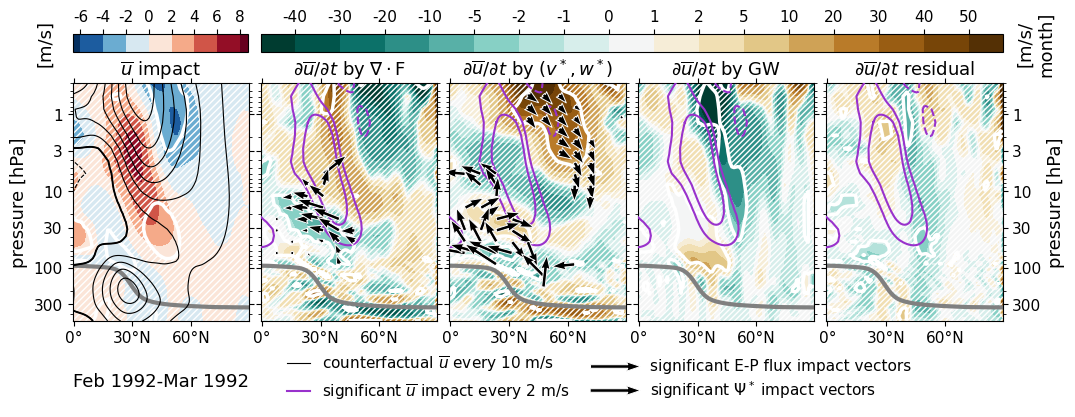

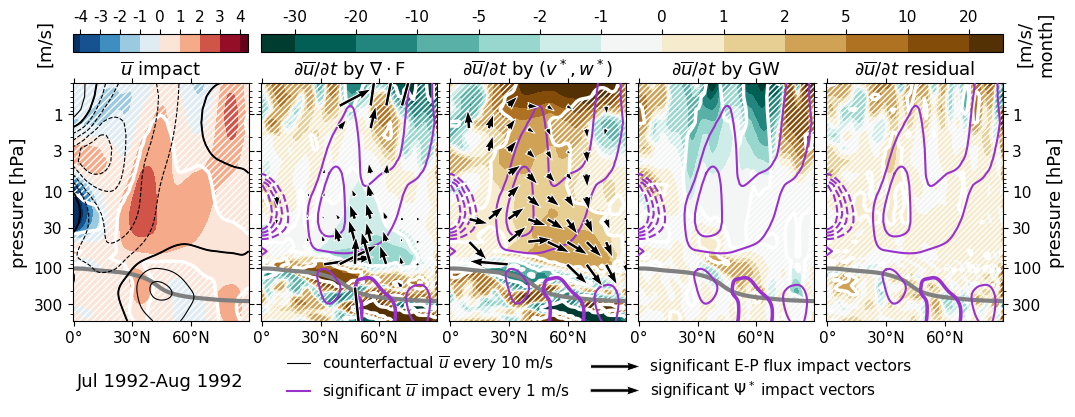

In [4]:
importlib.reload(putil)
importlib.reload(ces)

interpv = True
log_rvvec = True

# ========== TROPICS JAN-FEB 1992
latlim = [-30, 30]
plim   = [1, 150]
ulev = np.arange(-60, 20, 10)
ilev = [-6, -4, -2, 0, 2, 4, 6, 8, 10]
tendlev = [-10, -8, -5, -2, -1, 0, 1, 2, 5, 8, 10]
tlim   = [date(1992, 1, 1), date(1992, 2, 1)]
make_plot(latlim, plim, tlim, ulev, ilev, tendlev, epvscale=8e13, epdsp=2, epdslat=6, 
                                                   rvvscale=8,   rvdsp=2, rvdslat=6,
                                                   log_resvel_vectors=log_rvvec)
plt.savefig('figs/tropics_latpBudget_JF1992.pdf', dpi=200, bbox_inches='tight')

# ========== TROPICS JUNE-JULY 1992
ulev = np.arange(-60, 20, 10)
ilev = [-8, -6, -4, -2, 0, 1, 2, 3, 4]
tendlev = [-8, -5, -2, -1, -0.5, 0, 0.5, 1, 2, 5, 8]
tlim   = [date(1992, 6, 1), date(1992, 7, 1)]
make_plot(latlim, plim, tlim, ulev, ilev, tendlev, epvscale=5e13, epdsp=1, epdslat=6, 
                                                   rvvscale=10,   rvdsp=2, rvdslat=6, 
                                                   log_resvel_vectors=log_rvvec)
plt.savefig('figs/tropics_latpBudget_JJ1992.pdf', dpi=200, bbox_inches='tight')

# ========== NH MIDLATS JULY-AUG 1991
latlim = [-1, 91]
plim   = [0.3, 500]
latticks = [0, 30, 60, 90]
ulev = -(np.arange(-20, 70, 10)[::-1])
ilev = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
tendlev = [-30, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]
tlim   = [date(1991, 7, 1), date(1991, 8, 1)]
if(log_rvvec): rvvs = 12
else: rvvs = 1e10
make_plot(latlim, plim, tlim, ulev, ilev, tendlev, epvscale=2e13, epdsp=2, epdslat=6, 
                                                   rvvscale=rvvs, rvdsp=3, rvdslat=7, 
             interp_vectors=interpv, lat_ticks=latticks, log_resvel_vectors=log_rvvec)
plt.savefig('figs/NH_latpBudget_JA1991.pdf', dpi=200, bbox_inches='tight')

# ========== NH MIDLATS FEB-MAR 1992
ulev = np.arange(-20, 70, 10)
ilev = [-6, -4, -2, 0, 2, 4, 6, 8]
tendlev = [-40, -30, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20, 30, 40, 50]
tlim   = [date(1992, 2, 1), date(1992, 3, 1)]
log_rvvec = True
if(log_rvvec): rvvs = 15
else: rvvs = 1e10
make_plot(latlim, plim, tlim, ulev, ilev, tendlev, epvscale=2e14, epdsp=2, epdslat=8, 
                                                   rvvscale=rvvs, rvdsp=2, rvdslat=8,
             interp_vectors=interpv, lat_ticks=latticks, log_resvel_vectors=log_rvvec)
plt.savefig('figs/NH_latpBudget_FM1992.pdf', dpi=200, bbox_inches='tight')

# ========== NH MIDLATS JUL-AUG 1992
ulev = -(np.arange(-20, 70, 10)[::-1])
ilev = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
tendlev = [-30, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]
tlim   = [date(1992, 7, 1), date(1992, 8, 1)]
if(log_rvvec): rvvs = 12
else: rvvs = 1e10
make_plot(latlim, plim, tlim, ulev, ilev, tendlev, epvscale=3e13, epdsp=4, epdslat=8, 
                                                   rvvscale=rvvs, rvdsp=4, rvdslat=10, 
             interp_vectors=interpv, lat_ticks=latticks, log_resvel_vectors=log_rvvec)
plt.savefig('figs/NH_latpBudget_JA1992.pdf', dpi=200, bbox_inches='tight')

plt.show()

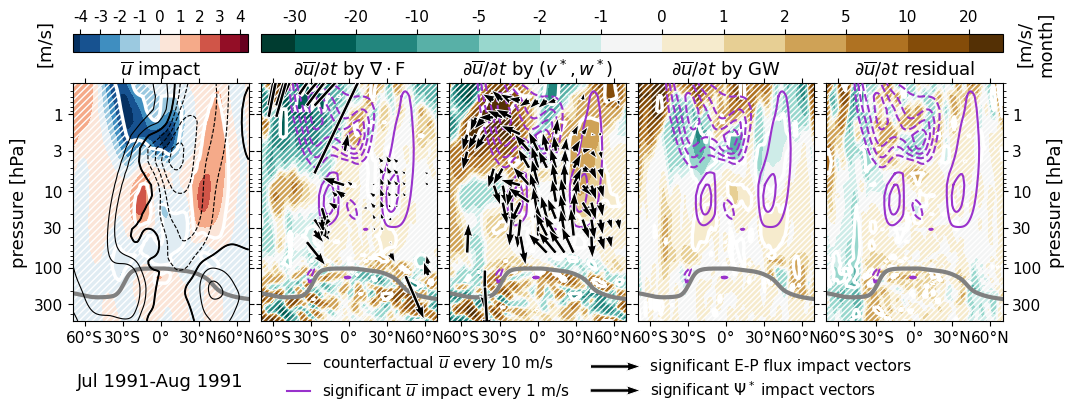

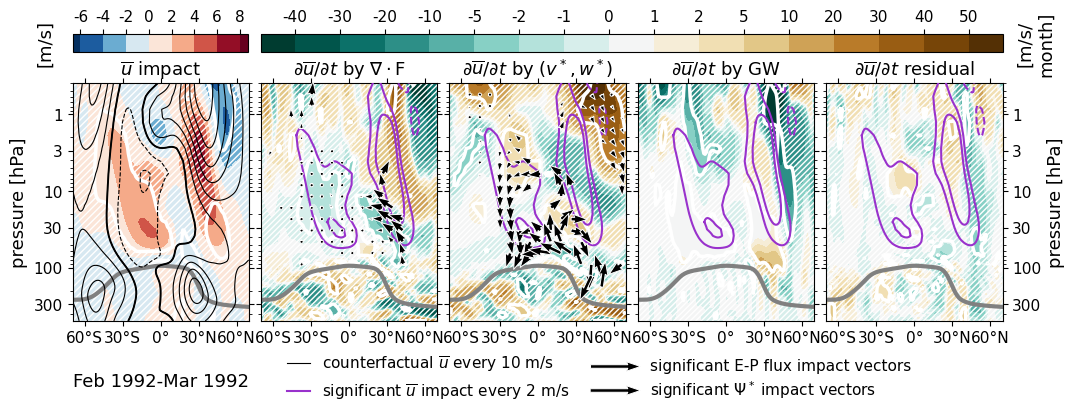

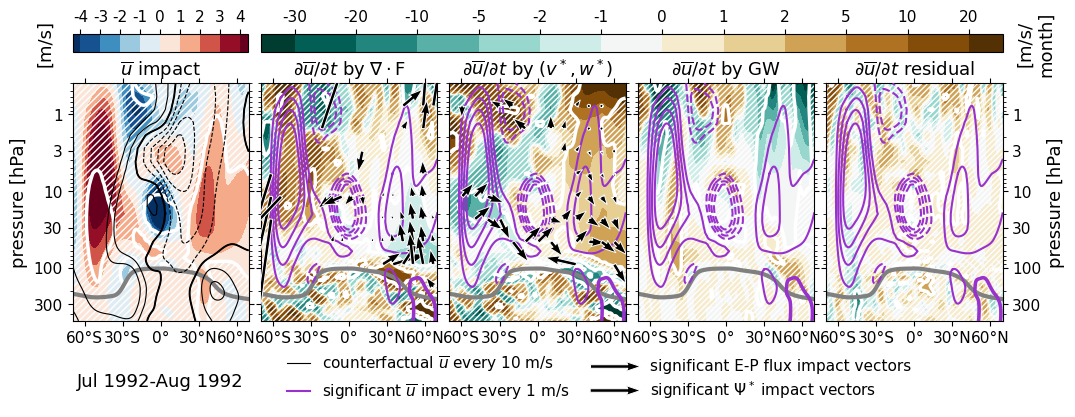

In [7]:
# ========== Global MIDLATS JULY-AUG 1991
latlim = [-70, 70]
plim   = [0.3, 500]
latticks = [-90, -60, -30, 0, 30, 60, 90]
ulev = -(np.arange(-20, 70, 10)[::-1])
ilev = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
tendlev = [-30, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]
tlim   = [date(1991, 7, 1), date(1991, 8, 1)]
if(log_rvvec): rvvs = 12
else: rvvs = 1e10
make_plot(latlim, plim, tlim, ulev, ilev, tendlev, epvscale=2e13, epdsp=2, epdslat=6, 
                                                   rvvscale=rvvs, rvdsp=3, rvdslat=7, 
             interp_vectors=interpv, lat_ticks=latticks, log_resvel_vectors=log_rvvec)
plt.savefig('figs/Global_latpBudget_JA1991.pdf', dpi=200, bbox_inches='tight')

# ========== Global MIDLATS FEB-MAR 1992
ulev = np.arange(-20, 70, 10)
ilev = [-6, -4, -2, 0, 2, 4, 6, 8]
tendlev = [-40, -30, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20, 30, 40, 50]
tlim   = [date(1992, 2, 1), date(1992, 3, 1)]
log_rvvec = True
if(log_rvvec): rvvs = 15
else: rvvs = 1e10
make_plot(latlim, plim, tlim, ulev, ilev, tendlev, epvscale=2e14, epdsp=2, epdslat=8, 
                                                   rvvscale=rvvs, rvdsp=2, rvdslat=8,
             interp_vectors=interpv, lat_ticks=latticks, log_resvel_vectors=log_rvvec)
plt.savefig('figs/Global_latpBudget_FM1992.pdf', dpi=200, bbox_inches='tight')

# ========== Global MIDLATS JUL-AUG 1992
ulev = -(np.arange(-20, 70, 10)[::-1])
ilev = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
tendlev = [-30, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]
tlim   = [date(1992, 7, 1), date(1992, 8, 1)]
if(log_rvvec): rvvs = 12
else: rvvs = 1e10
make_plot(latlim, plim, tlim, ulev, ilev, tendlev, epvscale=3e13, epdsp=4, epdslat=8, 
                                                   rvvscale=rvvs, rvdsp=4, rvdslat=10, 
             interp_vectors=interpv, lat_ticks=latticks, log_resvel_vectors=log_rvvec)
plt.savefig('figs/Global_latpBudget_JA1992.pdf', dpi=200, bbox_inches='tight')